# Unsupervised Learning - Project#1 - Auto MPG Dataset

The dataset was used in the 1983 American Statistical Association Exposition. The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous variables. 

Dataset: cars-dataset.csvView in a new window

Attribute Information:

Car Name – Name of the car

Cyl – No of cylinders in the car – Multivalued discrete

Disp – Displacement – continuous

Hp – Horsepower – continuous

Wt – Weight – continuous

Acc – Accleration – continuous

Yr – Model of the car – Multivalued discrete

Steps to follow:

1. EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points
2. Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) – 5 points
3. Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)
4. Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import train_test_split, cross_validate

In [2]:
df = pd.read_csv("cars-dataset.csv")

## Common Functions

In [3]:
def highlight_non_numeric(record):
    """
    Takes a record with 8 columns and returns an array indicating style (color) for each column
    the css property `'color: red'` for non-number
    strings, black otherwise.
    """
    output = ['', '', '', '', '', '', '', '']
    if (record.hp.isnumeric() == False):
        output[3] = 'background-color: #ffff99'
    return output

In [4]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = (s == s.max())
    return ['background-color: skyblue' if v else '' for v in is_max]

## 1. EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


#### Observation:
1. __hp__ (Horsepower) is a numeric measurement but it has datatype of __object__. This indicates some problem with the data in this column. Let's assess.

In [6]:
# List out the records where hp value is not numeric
df[df.hp.apply(lambda x: x.isnumeric() == False)].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98,?,2046,19,71,25
126,ford maverick,6,200,?,2875,17,74,21
330,renault lecar deluxe,4,85,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140,?,2905,14.3,80,23.6
354,renault 18i,4,100,?,2320,15.8,81,34.5
374,amc concord dl,4,151,?,3035,20.5,82,23


#### Observations:
1. There are a total of 6 records for 'ford pinto'. I thought they all would have same horsepower but they differ. Looks like every model (based on the year of launch) have different hp. Like in the dataset below,
 1. The model launched in year 1973 with displacement of 122 has hp of 85 
 2. The model launched in year 1974 with displacement of 122 has hp of 80
2. So my research shows that (ref = https://en.wikipedia.org/wiki/Ford_Pinto), the 'ford pinto' model launched in 1971 with displacement of 98 should have hp = 75. We shall impute this value for the missing record.
3. For 'ford maverick', I am unable to find proper history (https://en.wikipedia.org/wiki/Ford_Maverick_(Americas)) that helps to infer the value of hp for the record where hp is missing. So let's drop this record.
4. For 'renault lecar deluxe', the missing value can be imputed with hp = 51 (https://www.ultimatespecs.com/car-specs/Renault/23003/Renault-Le-Car-De-Luxe.html)
5. For 'ford mustang cobra', the missing hp = 132 (https://www.caranddriver.com/reviews/a15142429/1980-ford-mustang-cobra-review/)
6. For 'renault 18i', the missing hp = 73 (https://www.ultimatespecs.com/car-specs/Renault/M39/18). Look at the Petrol model launched in 1981.
7. For 'amc concord dl', the missing hp = 82 (https://www.automobile-catalog.com/make/amc/concord/concord_2-door_dl/1982.html)

###### Summary:
| car name | imputed value   |
|----------|-----------------|
|   ford pinto  | hp = 75|
|   ford maverick  | Delete record|
|   renault lecar deluxe  | hp = 51|
|   ford mustang cobra  | hp = 132|
|   renault 18i  | hp = 73|
|   amc concord dl  | hp = 82|


In [7]:
df[df['car name'] == 'ford pinto'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98,?,2046,19,71,25
112,ford pinto,4,122,85,2310,18.5,73,19
130,ford pinto,4,122,80,2451,16.5,74,26
168,ford pinto,4,140,83,2639,17,75,23
174,ford pinto,6,171,97,2984,14.5,75,18
206,ford pinto,4,140,72,2565,13.6,76,26.5


In [8]:
df[df['car name'] == 'ford maverick'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
17,ford maverick,6,200,85,2587,16,70,21
100,ford maverick,6,250,88,3021,16.5,73,18
126,ford maverick,6,200,?,2875,17,74,21
155,ford maverick,6,250,72,3158,19.5,75,15
193,ford maverick,6,200,81,3012,17.6,76,24


In [9]:
df[df['car name'] == 'renault lecar deluxe'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
330,renault lecar deluxe,4,85,?,1835,17.3,80,40.9


In [10]:
df[df['car name'] == 'ford mustang cobra'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
336,ford mustang cobra,4,140,?,2905,14.3,80,23.6


In [11]:
df[df['car name'] == 'renault 18i'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
354,renault 18i,4,100,?,2320,15.8,81,34.5


In [12]:
df[df['car name'] == 'amc concord dl'].style.apply(highlight_non_numeric, axis=1)

,car name,cyl,disp,hp,wt,acc,yr,mpg
374,amc concord dl,4,151,?,3035,20.5,82,23


In [13]:
df.loc[32, 'hp'] = '75'
df.loc[330, 'hp'] = '51'
df.loc[336, 'hp'] = '132'
df.loc[354, 'hp'] = '73'
df.loc[374, 'hp'] = '82'
df.drop(126, inplace=True, errors='ignore')
print("Impute Done")

Impute Done


In [14]:
df[df.hp.apply(lambda x: x.isnumeric() == False)]

,car name,cyl,disp,hp,wt,acc,yr,mpg


In [15]:
# Now cast the column from object to int64
df['hp'] = df['hp'].astype('int64', errors='ignore')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 397
Data columns (total 8 columns):
car name    397 non-null object
cyl         397 non-null int64
disp        397 non-null float64
hp          397 non-null int64
wt          397 non-null int64
acc         397 non-null float64
yr          397 non-null int64
mpg         397 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 27.9+ KB


## car name

In [17]:
# Grab the first word in 'car name' column which is the car company name
get_company = lambda x: x.split()[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

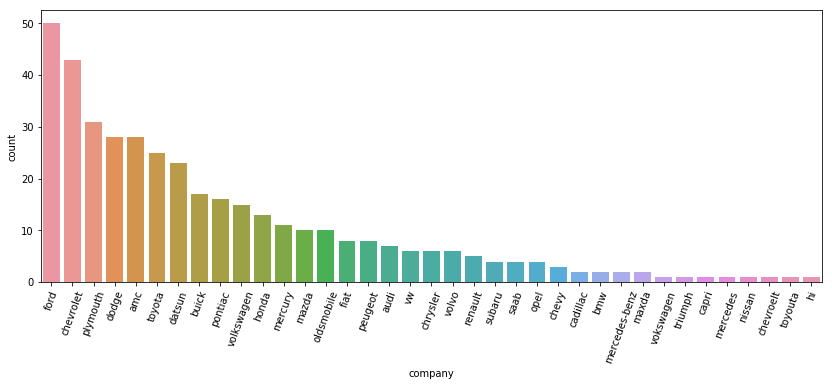

In [18]:
plt.figure(figsize=(14, 5))
df['company'] = df['car name'].apply(get_company)
sns.countplot(df['company'], order=df['company'].value_counts().index.tolist())
plt.xticks(rotation=70)

#### Observation:
1. So maximum cars in given dataset is from Ford followed by chevrolet, plymouth, dodge, amc etc.

## cyl

#### Domain Notes:
1. A Cylinder is the power unit of an engine; it's the chamber where the gasoline is burned and turned into power. Most cars and SUV engines have four, six, or eight cylinders. Generally, an engine with more cylinders produces more power, while an engine with fewer cylinders gets better fuel economy.

In [19]:
df['cyl'].value_counts(normalize=True)

4    0.513854
8    0.259446
6    0.209068
3    0.010076
5    0.007557
Name: cyl, dtype: float64

#### Observation:
1. Maximum number of cars in this dataset are 4 cylinders (51%) followed by 8 cylinders (26%) & 6 cylinders (21%)
2. Whereas there are very small number of cars with 3 and 5 cylinders
3. Looks like even number of cylinders are more popular as compared to odd number of cylinders

In [20]:
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(index=df['company'], columns=df['cyl']).style.background_gradient(cmap=cm)

cyl,3,4,5,6,8
company,,,,,
amc,0,3,0,17,8
audi,0,5,2,0,0
bmw,0,2,0,0,0
buick,0,3,0,7,7
cadillac,0,0,0,0,2
capri,0,1,0,0,0
chevroelt,0,0,0,1,0
chevrolet,0,15,0,10,18
chevy,0,1,0,0,2


* Each car company manufactures cars with different number of cylinders. Above dataset asseses where each car company stand w.r.t. cars with different number of cylinders that they manufacture.

#### Observations
1. In 4 Cylinders, __toyota__ is leading followed by datsun
2. In 6 Cylinders, __amc__ is leading followed by ford
3. In 8 Cylinders, __ford__ is leading followed by chevrolet
4. In 3 Cylinders, __mazda__ is leading 
5. In 5 Cylinders, __audi__ is leading followed by mercedec. Looks like 5 Cylinder is expensive category.

## disp

#### Domain notes:

Engine displacement is the combined swept volume of the pistons inside the cylinders of an engine. It is calculated from the bore (diameter of the cylinders), stroke (distance the piston travels), and number of cylinders. Displacement is an important factor, as it has a direct impact on an engine’s power output, fuel efficiency, and in some countries, how a vehicle is taxed.

The equation for calculating displacement is: Engine displacement = π/4 * bore² * stroke * number of cylinders. Displacement is usually measured in liters (L), cubic centimeters (CC), or cubic inches (CI).

##### Why engine displacement matters:

Engine displacement is a determining factor in the horsepower and torque that an engine produces, as well as how much fuel that engine consumes. Generally speaking, the higher an engine’s displacement the more power it can create, while the lower the displacement the less fuel it can consume. This is because displacement has a direct impact on how much fuel must be drawn into a cylinder to create power and maintain engine operation. A high-displacement engine draws in more of the air/fuel mixture per revolution; therefore more fuel is consumed. Other factors play into how powerful or efficient an engine is, such as fuel delivery, ignition systems, valvetrain layout, and forced induction, but in the simplest terms a bigger engine will be more powerful, and a smaller engine will be more efficient.

In [21]:
# Let's analyze cars with 4, 6 & 8 Cylinders
df_cyl_4 = df[df['cyl'] == 4]
df_cyl_6 = df[df['cyl'] == 6]
df_cyl_8 = df[df['cyl'] == 8]

Skew= 0.4416675615539831 , Kurtosis= -0.7442538678206461
Total cars = 204


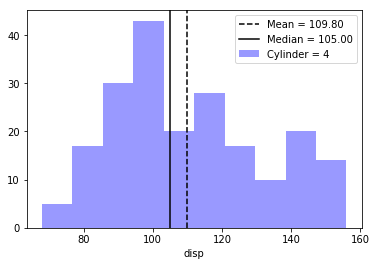

In [22]:
print("Skew=", df_cyl_4['disp'].skew(), ", Kurtosis=", df_cyl_4['disp'].kurtosis())
print("Total cars = %d" % df_cyl_4['disp'].shape[0])
ax=sns.distplot(df_cyl_4['disp'], hist=True, kde=False, label='Cylinder = 4' , color='b', bins=10)
ax.axvline(df_cyl_4['disp'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_4['disp'].mean())
ax.axvline(df_cyl_4['disp'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_4['disp'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 4 Cylinders, the distribution of displacement is very slightly right skewed
2. In cars with 4 Cylinders, most of the cars have displacement in the range 88-103

Skew= -0.78990908231512 , Kurtosis= -0.46505173305169967
Total cars = 83


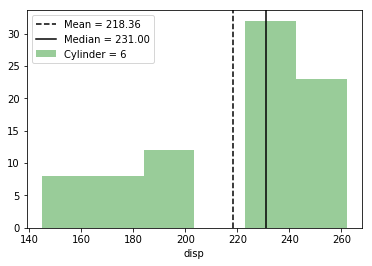

In [23]:
print("Skew=", df_cyl_6['disp'].skew(), ", Kurtosis=", df_cyl_6['disp'].kurtosis())
print("Total cars = %d" % df_cyl_6['disp'].shape[0])
ax=sns.distplot(df_cyl_6['disp'], hist=True, kde=False, label='Cylinder = 6', color='g')
ax.axvline(df_cyl_6['disp'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_6['disp'].mean())
ax.axvline(df_cyl_6['disp'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_6['disp'].median())
plt.legend(loc="upper left")

#### Observations:
1. In cars with 6 Cylinders, the distribution of displacement is slightly left skewed
1. In cars with 6 Cylinders, most of the cars have displacement in the range 223-262

Skew= 0.6012157481090544 , Kurtosis= -0.17155277620954967
Total cars = 103


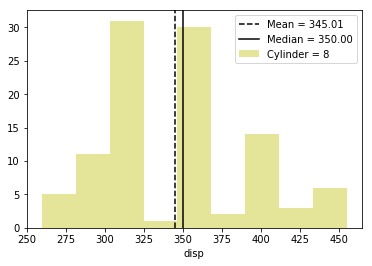

In [24]:
print("Skew=", df_cyl_8['disp'].skew(), ", Kurtosis=", df_cyl_8['disp'].kurtosis())
print("Total cars = %d" % df_cyl_8['disp'].shape[0])
ax=sns.distplot(df_cyl_8['disp'], hist=True, kde=False, label='Cylinder = 8', color='y')
ax.axvline(df_cyl_8['disp'].mean(),   color='black',  linestyle='--', label='Mean = %0.2f' %df_cyl_8['disp'].mean())
ax.axvline(df_cyl_8['disp'].median(), color='black',  linestyle='-',  label='Median = %0.2f' %df_cyl_8['disp'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 8 Cylinders, the distribution of displacement is slightly right skewed.
1. In cars with 8 Cylinders, most of the cars have displacement in the range 305-325 & 345-370

In [25]:
df_mean_median = df.pivot_table(index='cyl', values=['disp', 'hp', 'wt', 'acc', 'mpg'], aggfunc=['mean', 'median'])
df_mean_median

mean                                                 median         \
           acc        disp          hp        mpg           wt    acc   disp   
cyl                                                                            
3    13.250000   72.500000   99.250000  20.550000  2398.500000   13.5   70.0   
4    16.601471  109.796569   78.387255  29.286765  2308.127451   16.2  105.0   
5    18.633333  145.000000   82.333333  27.366667  3103.333333   19.9  131.0   
6    16.254217  218.361446  101.506024  19.973494  3202.120482   16.0  231.0   
8    12.955340  345.009709  158.300971  14.963107  4114.718447   13.0  350.0   

                         
        hp    mpg    wt  
cyl                      
3     98.5  20.25  2375  
4     77.0  28.25  2232  
5     77.0  25.40  2950  
6    100.0  19.00  3210  
8    150.0  14.00  4140

          disp       cyl
disp  1.000000  0.950798
cyl   0.950798  1.000000


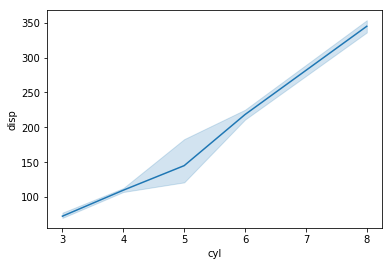

In [26]:
# Demonstrate correlation between No. of Cylinders and Displacement of cars
print(df[['disp', 'cyl']].corr())
sns.lineplot(x='cyl', y='disp', data=df)

Text(0.5, 0, 'Cylinders')

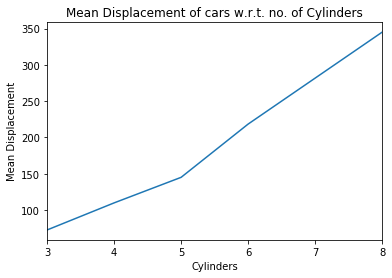

In [27]:
# Demonstrate correlation between No. of Cylinders and Mean Displacement of Cars
df_mean_median['mean', 'disp'].plot(use_index=True, 
                                                 title="Mean Displacement of cars w.r.t. no. of Cylinders", 
                                                 kind='line')
plt.ylabel("Mean Displacement")
plt.xlabel("Cylinders")

#### Observation:
1. As number of Cylinders increase, mean displacement increases. It's pretty linear relationship.
2. Statistically also it's showing correlation coefficient as 0.950798

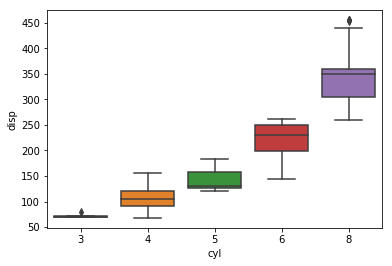

In [28]:
sns.boxplot('cyl', 'disp', data=df)

## hp

Skew= 0.2794632248508319 , Kurtosis= 0.2907145542421845
Total cars = 204


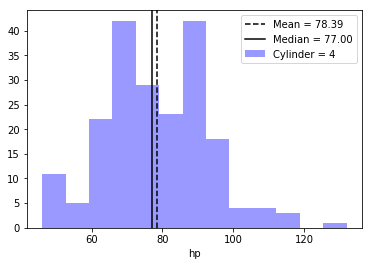

In [29]:
print("Skew=", df_cyl_4['hp'].skew(), ", Kurtosis=", df_cyl_4['hp'].kurtosis())
print("Total cars = %d" % df_cyl_4['hp'].shape[0])
ax=sns.distplot(df_cyl_4['hp'], hist=True, kde=False, label='Cylinder = 4' , color='b')
ax.axvline(df_cyl_4['hp'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_4['hp'].mean())
ax.axvline(df_cyl_4['hp'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_4['hp'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 4 Cylinders, the distribution of hp is very slightly right skewed
2. In cars with 4 Cylinders, most of the cars have hp in the range 60-98

Skew= 1.0149033961638814 , Kurtosis= 3.8558728983501345
Total cars = 83


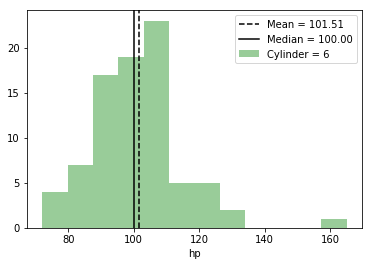

In [30]:
print("Skew=", df_cyl_6['hp'].skew(), ", Kurtosis=", df_cyl_6['hp'].kurtosis())
print("Total cars = %d" % df_cyl_6['hp'].shape[0])
ax=sns.distplot(df_cyl_6['hp'], hist=True, kde=False, label='Cylinder = 6', color='g')
ax.axvline(df_cyl_6['hp'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_6['hp'].mean())
ax.axvline(df_cyl_6['hp'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_6['hp'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 6 Cylinders, the distribution of hp is slightly right skewed
2. In cars with 6 Cylinders, most of the cars have hp in the range 88-110

Skew= 0.6487009847994352 , Kurtosis= 0.3397392357307809
Total cars = 103


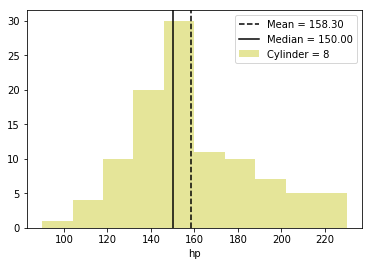

In [31]:
print("Skew=", df_cyl_8['hp'].skew(), ", Kurtosis=", df_cyl_8['hp'].kurtosis())
print("Total cars = %d" % df_cyl_8['hp'].shape[0])
ax=sns.distplot(df_cyl_8['hp'], hist=True, kde=False, label='Cylinder = 8', color='y')
ax.axvline(df_cyl_8['hp'].mean(),   color='black',  linestyle='--', label='Mean = %0.2f' %df_cyl_8['hp'].mean())
ax.axvline(df_cyl_8['hp'].median(), color='black',  linestyle='-',  label='Median = %0.2f' %df_cyl_8['hp'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 8 Cylinders, the distribution of hp is slightly right skewed
2. In cars with 8 Cylinders, most of the cars have hp in the range 132-160, with some coming with even higher hp.

          cyl        hp
cyl  1.000000  0.840902
hp   0.840902  1.000000


Text(0.5, 1.0, 'Horsepower of cars w.r.t. no. of Cylinders')

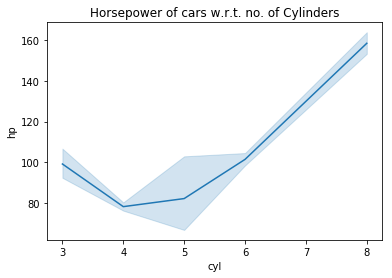

In [32]:
# Demonstrate correlation between No. of Cylinders and hp of cars
print(df[['cyl', 'hp']].corr())
sns.lineplot(x='cyl', y='hp', data=df)
plt.title("Horsepower of cars w.r.t. no. of Cylinders")

Text(0.5, 0, 'Cylinders')

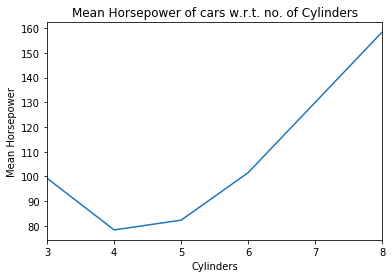

In [33]:
df_mean_median['mean', 'hp'].plot(use_index=True, 
                                                 title="Mean Horsepower of cars w.r.t. no. of Cylinders", 
                                                 kind='line')
plt.ylabel("Mean Horsepower")
plt.xlabel("Cylinders")

#### Observation:
1. In general as the number of cylinders increase, cars' horsepower also increases. This has an exception at cars with 3 cylinders which has higher horsepower than cars with 4 cylinders.
2. Statistically also it's showing correlation coefficient of 0.840902

          disp        hp       cyl
disp  1.000000  0.896036  0.950798
hp    0.896036  1.000000  0.840902
cyl   0.950798  0.840902  1.000000


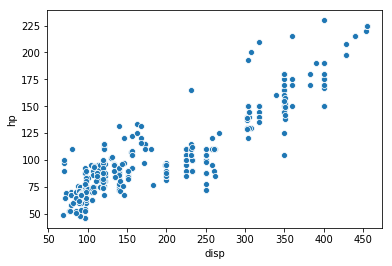

In [34]:
print(df[['disp', 'hp', 'cyl']].corr())
sns.scatterplot(df['disp'], df['hp'])

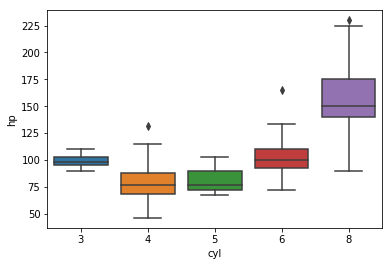

In [35]:
sns.boxplot('cyl', 'hp', data=df)

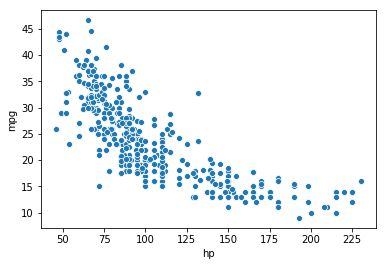

In [36]:
sns.scatterplot('hp', 'mpg', data=df)

## wt

Skew= 0.5606420406645036 , Kurtosis= -0.2197837844245507
Total cars = 204


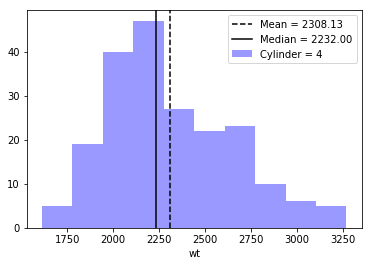

In [37]:
print("Skew=", df_cyl_4['wt'].skew(), ", Kurtosis=", df_cyl_4['wt'].kurtosis())
print("Total cars = %d" % df_cyl_4['wt'].shape[0])
ax=sns.distplot(df_cyl_4['wt'], hist=True, kde=False, label='Cylinder = 4' , color='b')
ax.axvline(df_cyl_4['wt'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_4['wt'].mean())
ax.axvline(df_cyl_4['wt'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_4['wt'].median())
plt.legend(loc="upper right")

#### Observations:
1. In cars with 4 Cylinders, the distribution of weight is slightly right skewed
2. In cars with 4 Cylinders, most of the cars have weight in the range 1950-2250

Skew= 0.053328093527783 , Kurtosis= -0.6181917191251283
Total cars = 83


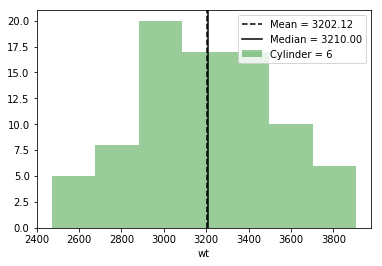

In [38]:
print("Skew=", df_cyl_6['wt'].skew(), ", Kurtosis=", df_cyl_6['wt'].kurtosis())
print("Total cars = %d" % df_cyl_6['wt'].shape[0])
ax=sns.distplot(df_cyl_6['wt'], hist=True, kde=False, label='Cylinder = 6', color='g')
ax.axvline(df_cyl_6['wt'].mean(),   color='black', linestyle='--', label='Mean = %0.2f' %df_cyl_6['wt'].mean())
ax.axvline(df_cyl_6['wt'].median(), color='black', linestyle='-',  label='Median = %0.2f' %df_cyl_6['wt'].median())
plt.legend(loc="upper right")

###### Observations:
1. In cars with 6 Cylinders, the distribution of weight is normal (with mean and median very close to each other)
2. In cars with 6 Cylinders, most of the cars have weight in the range 2900-3500

Skew= -0.10347838589487228 , Kurtosis= -0.40509562228711626
Total cars = 103


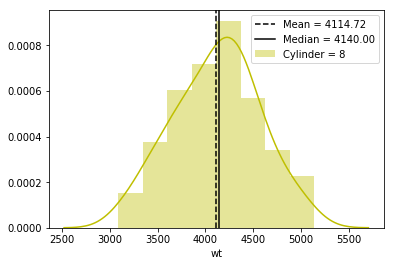

In [39]:
print("Skew=", df_cyl_8['wt'].skew(), ", Kurtosis=", df_cyl_8['wt'].kurtosis())
print("Total cars = %d" % df_cyl_8['wt'].shape[0])
ax=sns.distplot(df_cyl_8['wt'], hist=True, kde=True, label='Cylinder = 8', color='y')
ax.axvline(df_cyl_8['wt'].mean(),   color='black',  linestyle='--', label='Mean = %0.2f' %df_cyl_8['wt'].mean())
ax.axvline(df_cyl_8['wt'].median(), color='black',  linestyle='-',  label='Median = %0.2f' %df_cyl_8['wt'].median())
plt.legend(loc="upper right")

###### Observations:
1. In cars with 8 Cylinders, the distribution of weight is normal (with mean and median very close to each other)
2. In cars with 8 Cylinders, most of the cars have weight in the range 3600-4700

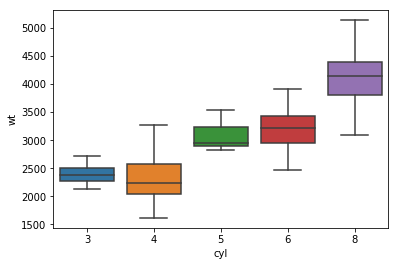

In [40]:
sns.boxplot('cyl', 'wt', data=df)

          cyl        wt
cyl  1.000000  0.896239
wt   0.896239  1.000000


Text(0.5, 1.0, 'Weight of cars w.r.t. no. of Cylinders')

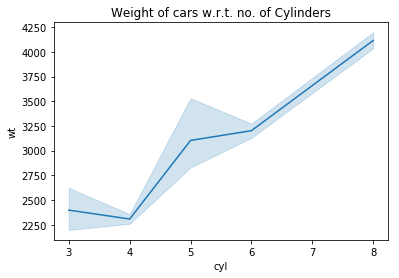

In [41]:
# Demonstrate correlation between No. of Cylinders and wt of cars
print(df[['cyl', 'wt']].corr())
sns.lineplot(x='cyl', y='wt', data=df)
plt.title("Weight of cars w.r.t. no. of Cylinders")

Text(0.5, 0, 'Cylinders')

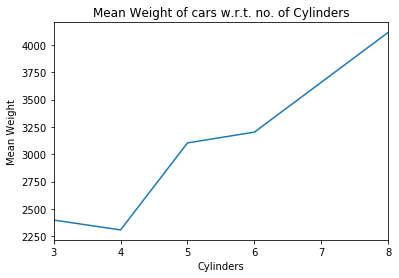

In [42]:
df_mean_median['mean', 'wt'].plot(use_index=True, 
                                                 title="Mean Weight of cars w.r.t. no. of Cylinders", 
                                                 kind='line')
plt.ylabel("Mean Weight")
plt.xlabel("Cylinders")

## acc

          cyl       acc
cyl  1.000000 -0.506078
acc -0.506078  1.000000


Text(0.5, 1.0, 'Acceleration of cars w.r.t. no. of Cylinders')

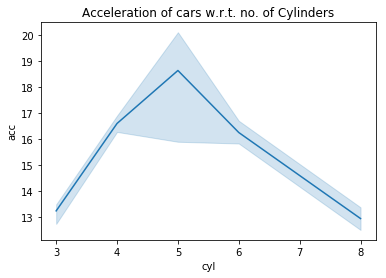

In [43]:
# Demonstrate correlation between No. of Cylinders and acceleration of cars
print(df[['cyl', 'acc']].corr())
sns.lineplot(x='cyl', y='acc', data=df)
plt.title("Acceleration of cars w.r.t. no. of Cylinders")

Text(0.5, 0, 'Cylinders')

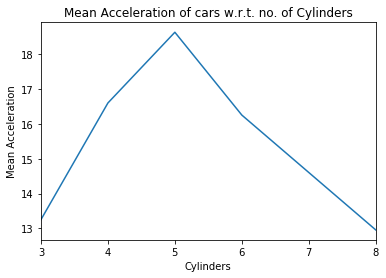

In [44]:
df_mean_median['mean', 'acc'].plot(use_index=True, 
                                                 title="Mean Acceleration of cars w.r.t. no. of Cylinders", 
                                                 kind='line')
plt.ylabel("Mean Acceleration")
plt.xlabel("Cylinders")

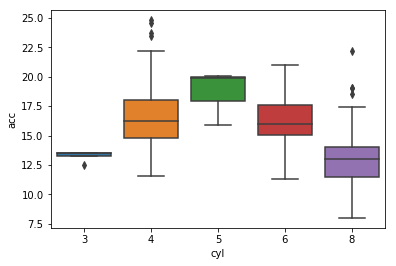

In [45]:
sns.boxplot('cyl', 'acc', data=df)

## yr

In [46]:
(df['yr'].value_counts(normalize=True)*100).sort_index()

70     7.304786
71     7.052897
72     7.052897
73    10.075567
74     6.549118
75     7.556675
76     8.564232
77     7.052897
78     9.068010
79     7.304786
80     7.304786
81     7.304786
82     7.808564
Name: yr, dtype: float64

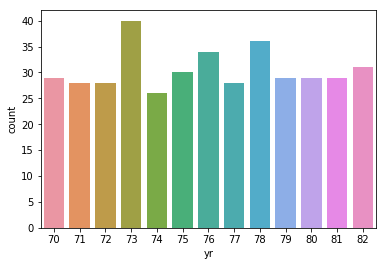

In [47]:
sns.countplot(df['yr'])

#### Observation:
1. Maximum number of cars (about 10.07 %) are from year 1973, followed by year 1978 (9.06 %. It has to be as I was born this year :)) & 1976 (8.56%)
2. Minimum number of cars (about  6.54 %) are from year 1974
3. Else for other years it's pretty much constant around 7%

In [48]:
# Let's understand year wise which company has been leading in production
pd.crosstab(index=df['yr'], columns=df['company']).T.style.apply(highlight_max)

yr,70,71,72,73,74,75,76,77,78,79,80,81,82
company,,,,,,,,,,,,,
amc,4,3,2,4,3,3,3,0,2,2,1,0,1
audi,1,0,0,1,1,1,0,0,1,0,2,0,0
bmw,1,0,0,0,0,0,0,1,0,0,0,0,0
buick,2,0,1,2,1,2,0,2,2,2,0,2,1
cadillac,0,0,0,0,0,0,1,0,0,1,0,0,0
capri,0,0,0,0,0,0,1,0,0,0,0,0,0
chevroelt,0,0,0,0,0,1,0,0,0,0,0,0,0
chevrolet,3,4,3,6,3,3,4,4,3,3,2,1,4
chevy,1,0,0,0,0,0,1,0,0,0,0,0,1


#### Observation:
01. For the year 1970; amc, ford and plymouth are leading (4 cars each)
02. For the year 1971; ford is leading (5 cars)
03. For the year 1972; ford is leading (4 cars)
04. For the year 1973, chevrolet is leading (6 cars)
05. For the year 1974; amc, chevrolet, fiat and ford are leading (3 cars each)
06. ...
07. ...


13. For the year 1982; chevrolet and ford are leading (4 cars each)

In [49]:
# Let's understand year wise how many cars with different No. of cylinders were manufactured
pd.crosstab(index=df['yr'], columns=df['cyl']).T.style.apply(highlight_max)

yr,70,71,72,73,74,75,76,77,78,79,80,81,82
cyl,,,,,,,,,,,,,
3,0,0,1,1,0,0,0,1,0,0,1,0,0
4,7,13,14,11,15,12,15,14,17,12,25,21,28
5,0,0,0,0,0,0,0,0,1,1,1,0,0
6,4,8,0,8,6,12,10,5,12,6,2,7,3
8,18,7,13,20,5,6,9,8,6,10,0,1,0


#### Observation:
1. In the year 1970; 8 Cylinder cars were manufactured the most
2. In the year 1971, 1972, 1974-1982; 4 Cylinder cars were manufactured the most
3. In the year 1973; 8 Cylinder cars were manufactured the most
4. In the year 1975; along with 4 Cylinder, 6 Cylinder cars were manufactured the most

Text(0, 0.5, 'Displacement')

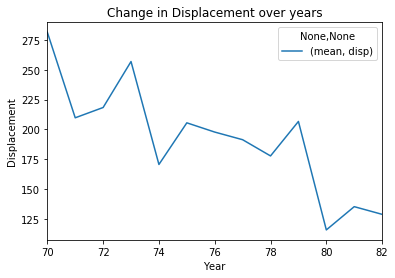

In [50]:
df.pivot_table(index='yr', values=['disp'], aggfunc=['mean']).plot(kind='line', 
                                                                  use_index=True, 
                                                                  title="Change in Displacement over years")
plt.xlabel("Year")
plt.ylabel("Displacement")

#### Observation:
1. There have been some peaks but overall trend is decreasing displacement over years
2. Question: Why do we see the trend of reduction in displacement?
 1. The reason is in the beginning years (or some of the years in between) car companies manufactured more of 6 & 8 Cylinder cars and less of 4 Cylinder cars but later years they reduced manufacturing of 6 & 8 Cylinder cars as compared to (may be) more popular 4 Cylinder cars.

Text(0, 0.5, 'Horsepower')

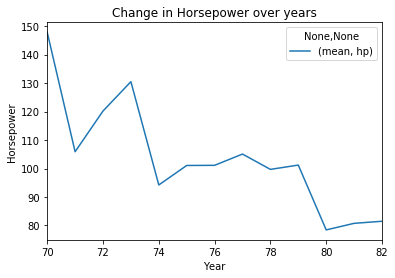

In [51]:
df.pivot_table(index='yr', values=['hp'], aggfunc=['mean']).plot(kind='line', 
                                                                  use_index=True, 
                                                                  title="Change in Horsepower over years")
plt.xlabel("Year")
plt.ylabel("Horsepower")

#### Observation:
1. Like Displacement, horsepower also has reducing trend over the years

Text(0, 0.5, 'Weight')

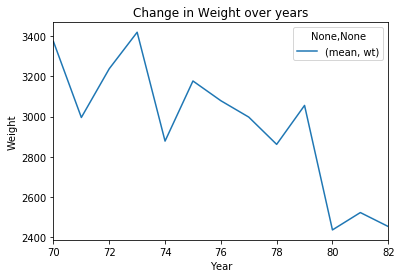

In [52]:
df.pivot_table(index='yr', values=['wt'], aggfunc=['mean']).plot(kind='line', 
                                                                  use_index=True, 
                                                                  title="Change in Weight over years")
plt.xlabel("Year")
plt.ylabel("Weight")

#### Observation:
1. Like Displacement & Horsepower, weight also has reducing trend over the years

Text(0, 0.5, 'Acceleration')

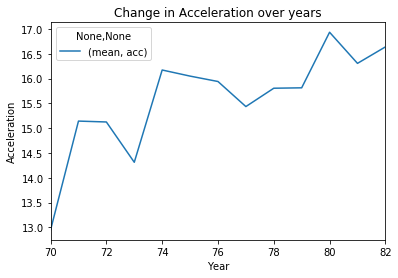

In [53]:
df.pivot_table(index='yr', values=['acc'], aggfunc=['mean']).plot(kind='line', 
                                                                  use_index=True, 
                                                                  title="Change in Acceleration over years")
plt.xlabel("Year")
plt.ylabel("Acceleration")

#### Observation:
1. Great acceleration is showing increasing trend over the years

Text(0, 0.5, 'MPG')

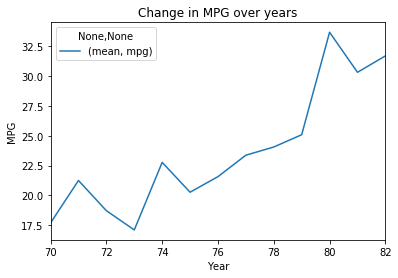

In [54]:
df.pivot_table(index='yr', values=['mpg'], aggfunc=['mean']).plot(kind='line', 
                                                                  use_index=True, 
                                                                  title="Change in MPG over years")
plt.xlabel("Year")
plt.ylabel("MPG")

#### Observation:
1. Even mpg is showing increasing trend over the years
2. Car companies must be getting more innovative over time to manufacture more fuel efficient cars

## company

In [55]:
# Which company cars have been leading on different parameters
df.pivot_table(index='company', values=['disp', 'hp', 'wt', 'acc', 'mpg'], aggfunc=['mean']).style.apply(highlight_max)

In [56]:
# We can go one level below and compare different parameters ( like displacement shown below) 
# categorised for car company-number of cylinders combination
df.pivot_table(index=['company', 'cyl'], 
               values=['disp'], 
               aggfunc=['min', 'mean', 'max'])\
      .style.background_gradient(cmap=cm)

# 2. Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset)

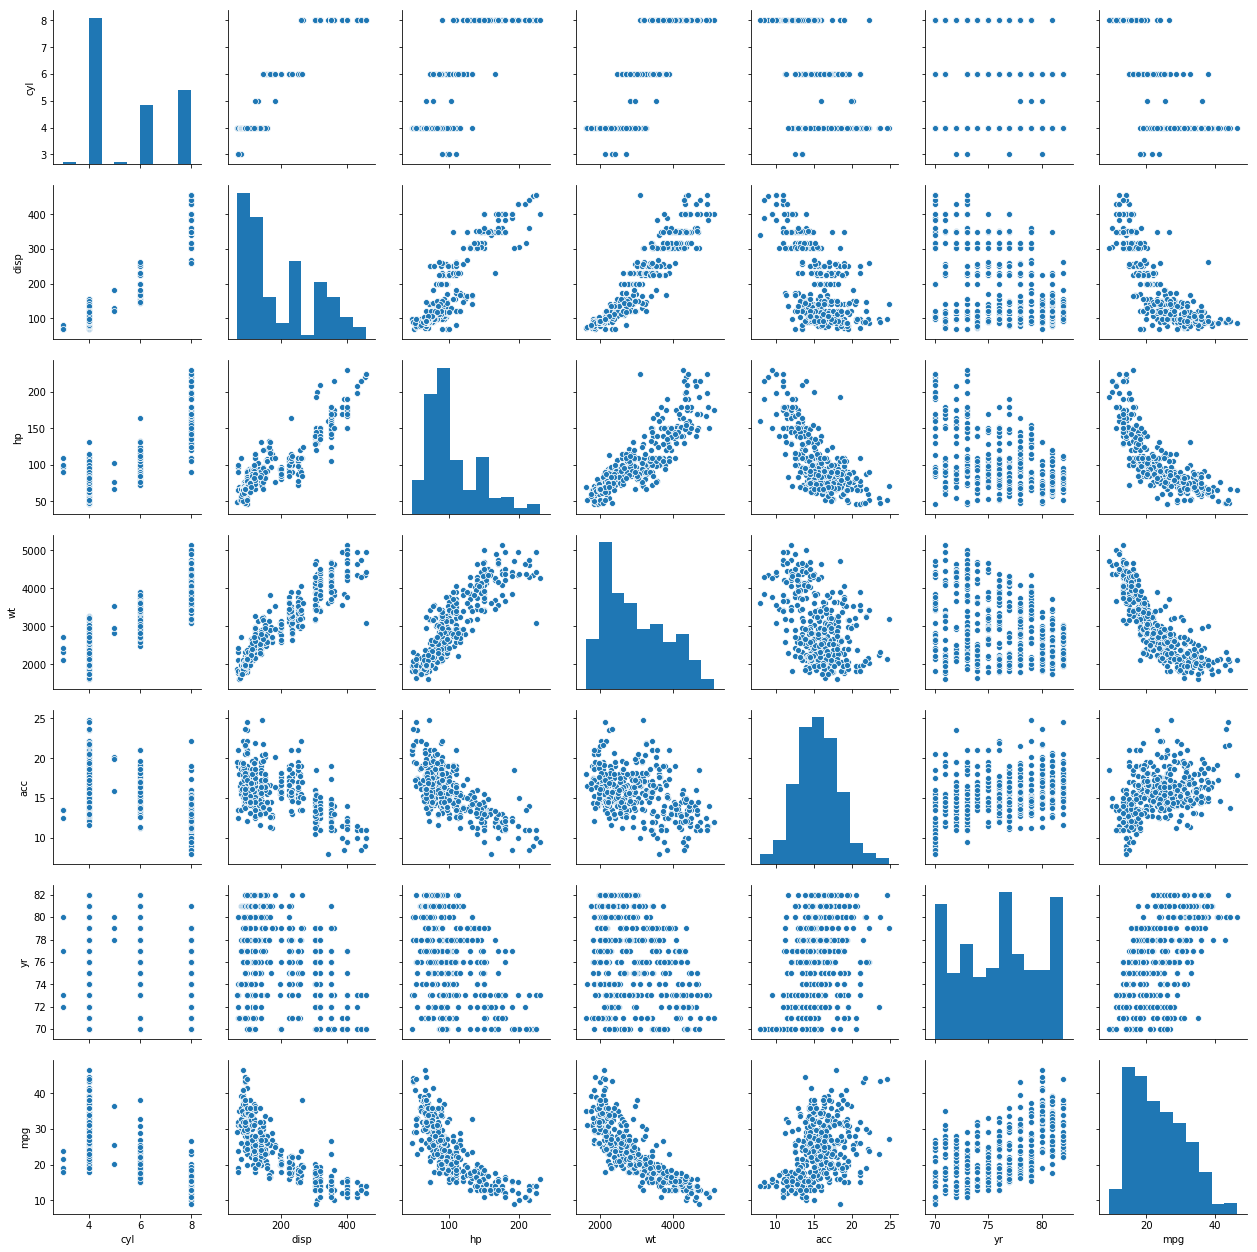

In [57]:
sns.pairplot(df)

#### Observation:
1. Already have done detailed Univariate and Bivariate analysis before. Overall, I feel there are 3 clusters in this dataset.

# 3. Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters

## K Means

In [58]:
import scipy.stats as st

In [59]:
X1 = df.drop(['car name', 'yr', 'company'], axis=1).apply(st.zscore)
X2 = pd.get_dummies(df[['yr', 'company']], columns=['yr', 'company'])
X = X1.join(X2)
X.head()

,cyl,disp,hp,wt,acc,mpg,yr_70,yr_71,yr_72,yr_73,...,company_renault,company_saab,company_subaru,company_toyota,company_toyouta,company_triumph,company_vokswagen,company_volkswagen,company_volvo,company_vw
0,1.49731,1.089397,0.672122,0.629803,-1.293002,-0.706453,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.49731,1.501791,1.583702,0.852989,-1.474375,-1.090332,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.49731,1.194893,1.193025,0.549503,-1.655748,-0.706453,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.49731,1.060625,1.193025,0.545961,-1.293002,-0.962373,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.49731,1.041444,0.932574,0.564855,-1.837121,-0.834413,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
distortions = []
K = range(1, 11)
for k in K:
    model_kmean = KMeans(n_clusters=k, random_state=17).fit(X)
    sil_score = 0
    if k >=2:
        sil_score = silhouette_score(X, model_kmean.labels_, random_state=17)
    distortions.append(sum(np.min(cdist(X, model_kmean.cluster_centers_, metric='euclidean'), axis=1)**2 / (X.shape[0])))
    print("Cluster Size = ", k, " , Iterations = ", model_kmean.n_iter_, ", Silhoutte Score = ", sil_score, ", Distorations", distortions)

Cluster Size =  1  , Iterations =  2 , Silhoutte Score =  0 , Distorations [7.860490200432726]
Cluster Size =  2  , Iterations =  3 , Silhoutte Score =  0.4173468233084891 , Distorations [7.860490200432726, 4.208933441313229]
Cluster Size =  3  , Iterations =  10 , Silhoutte Score =  0.26627614323303267 , Distorations [7.860490200432726, 4.208933441313229, 3.3490207208188445]
Cluster Size =  4  , Iterations =  10 , Silhoutte Score =  0.20020024645552537 , Distorations [7.860490200432726, 4.208933441313229, 3.3490207208188445, 3.042958162062385]
Cluster Size =  5  , Iterations =  7 , Silhoutte Score =  0.19077885194966518 , Distorations [7.860490200432726, 4.208933441313229, 3.3490207208188445, 3.042958162062385, 2.8559544251031435]
Cluster Size =  6  , Iterations =  5 , Silhoutte Score =  0.1563222650011758 , Distorations [7.860490200432726, 4.208933441313229, 3.3490207208188445, 3.042958162062385, 2.8559544251031435, 2.7011057310705424]
Cluster Size =  7  , Iterations =  7 , Silhoutte

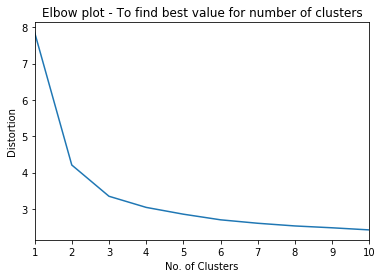

In [61]:
plt.title("Elbow plot - To find best value for number of clusters")
plt.xlabel("No. of Clusters")
plt.ylabel("Distortion")
plt.xlim(left=1, right = 10)
plt.plot(K, distortions)

In [62]:
optimum_clusters=2

In [63]:
distortions

[7.860490200432726,
 4.208933441313229,
 3.3490207208188445,
 3.042958162062385,
 2.8559544251031435,
 2.7011057310705424,
 2.6063575431512187,
 2.532451416748266,
 2.48174713098078,
 2.423383882163007]

In [64]:
np.diff(distortions, n=1)*(-1)

array([3.65155676, 0.85991272, 0.30606256, 0.18700374, 0.15484869,
       0.09474819, 0.07390613, 0.05070429, 0.05836325])

In [65]:
model_kmean = KMeans(n_clusters=optimum_clusters, random_state=17).fit(X)
model_kmean.cluster_centers_ 

array([[-5.23441422e-01, -5.12273812e-01, -5.03464942e-01,
        -4.76791576e-01,  3.44183169e-01,  3.90025552e-01,
         3.75426621e-02,  7.16723549e-02,  5.11945392e-02,
         6.82593857e-02,  7.16723549e-02,  8.19112628e-02,
         8.53242321e-02,  6.82593857e-02,  9.55631399e-02,
         6.82593857e-02,  9.89761092e-02,  9.55631399e-02,
         1.05802048e-01,  6.48464164e-02,  2.38907850e-02,
         6.82593857e-03,  3.07167235e-02,  6.93889390e-18,
         3.41296928e-03,  3.41296928e-03,  8.53242321e-02,
         3.41296928e-03,  6.82593857e-03,  7.84982935e-02,
         5.46075085e-02,  2.73037543e-02,  1.02389078e-01,
         3.46944695e-18,  4.43686007e-02,  6.82593857e-03,
         3.41296928e-02,  3.41296928e-03,  6.82593857e-03,
         2.04778157e-02,  3.41296928e-03,  1.36518771e-02,
         1.36518771e-02,  2.73037543e-02,  7.16723549e-02,
         3.07167235e-02,  1.70648464e-02,  1.36518771e-02,
         1.36518771e-02,  8.53242321e-02,  3.41296928e-0

In [66]:
pd.DataFrame(columns=X.columns, data=model_kmean.cluster_centers_)

,cyl,disp,hp,wt,acc,mpg,yr_70,yr_71,yr_72,yr_73,...,company_renault,company_saab,company_subaru,company_toyota,company_toyouta,company_triumph,company_vokswagen,company_volkswagen,company_volvo,company_vw
0,-0.523441,-0.512274,-0.503465,-0.476792,0.344183,0.390026,0.037543,0.071672,0.051195,0.068259,...,1.706485e-02,1.365188e-02,1.365188e-02,8.532423e-02,3.412969e-03,3.412969e-03,3.412969e-03,5.119454e-02,2.047782e-02,2.047782e-02
1,1.474696,1.443233,1.418416,1.343269,-0.969670,-1.098822,0.173077,0.067308,0.125000,0.192308,...,2.949030e-17,6.938894e-18,6.938894e-18,1.387779e-17,1.734723e-18,1.734723e-18,1.734723e-18,-4.857226e-17,-1.387779e-17,-1.387779e-17


In [67]:
model_kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

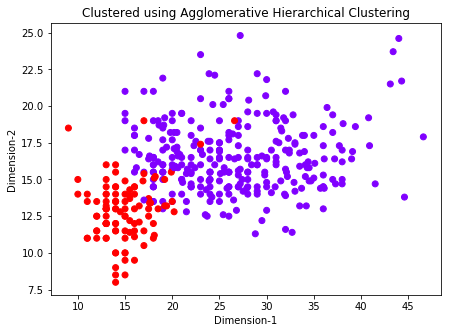

In [68]:
plt.figure(figsize=(7, 5))
plt.title("Clustered using Agglomerative Hierarchical Clustering")
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.scatter(df['mpg'], df['acc'], c=model_kmean.labels_, cmap='rainbow')  # plot points with cluster dependent colors
plt.show()

In [69]:
# Perform Silhoutte Analysis to validate Clusters

In [70]:
sil_score = silhouette_score(X, model_kmean.labels_, random_state=17)
sil_score

0.4173468233084891

In [71]:
X.shape

(397, 56)

In [72]:
sil_samples = silhouette_samples(X, model_kmean.labels_)
sil_samples.mean()

0.4173468233084891

## Hierarchical Clustering

In [73]:
Z = linkage(X, 'ward', metric='euclidean')

In [74]:
Z

array([[1.28000000e+02, 1.44000000e+02, 2.14902262e-01, 2.00000000e+00],
       [6.40000000e+01, 7.50000000e+01, 2.32294720e-01, 2.00000000e+00],
       [8.70000000e+01, 1.15000000e+02, 2.78955630e-01, 2.00000000e+00],
       ...,
       [7.87000000e+02, 7.89000000e+02, 1.45654180e+01, 2.21000000e+02],
       [7.84000000e+02, 7.90000000e+02, 2.61242244e+01, 2.99000000e+02],
       [7.88000000e+02, 7.91000000e+02, 5.35146836e+01, 3.97000000e+02]])

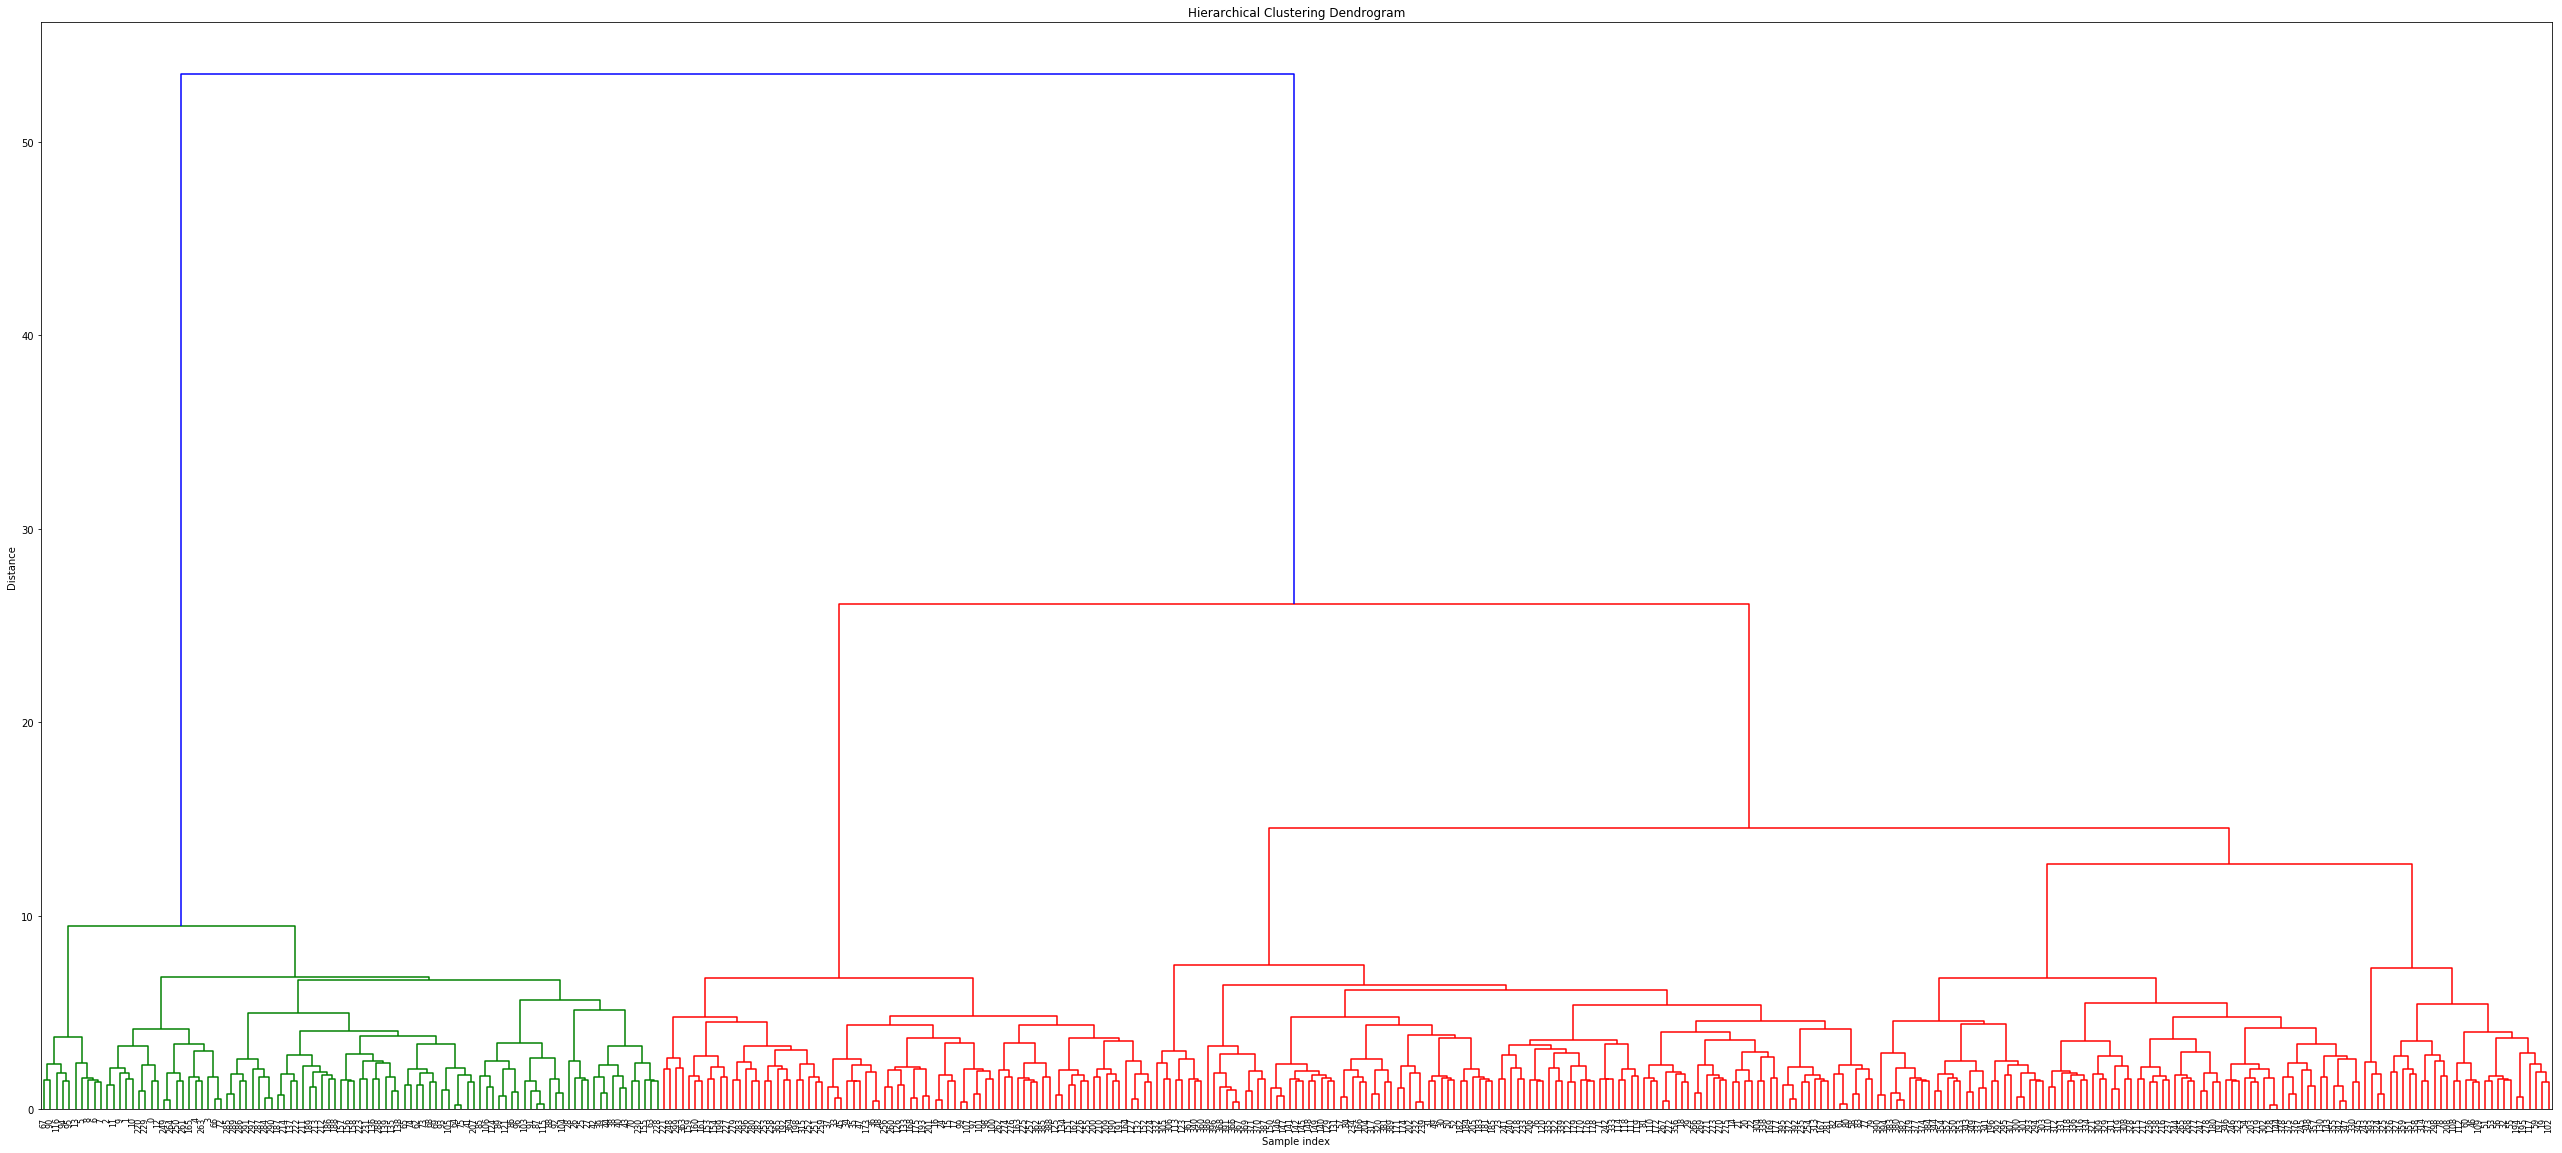

In [75]:
plt.figure(figsize=(45, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_leaf_counts = True
)
plt.show()

In [76]:
# Looks like cutting at max distance 30 will create 2 appropriate clusters
max_d = 30

In [77]:
clusters = fcluster(Z, max_d, criterion='distance')
clusters -= 1
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [78]:
df_comp = pd.DataFrame()
df_comp['KMeans'] = model_kmean.labels_
df_comp['Agglomerative'] = clusters
print(df_comp['KMeans'].value_counts())
print(df_comp['Agglomerative'].value_counts())

0    293
1    104
Name: KMeans, dtype: int64
1    299
0     98
Name: Agglomerative, dtype: int64


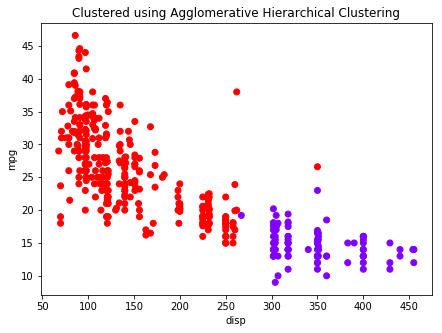

In [79]:
plt.figure(figsize=(7, 5))
plt.title("Clustered using Agglomerative Hierarchical Clustering")
plt.xlabel("disp")
plt.ylabel("mpg")
plt.scatter(df['disp'], df['mpg'], c=clusters, cmap='rainbow')  # plot points with cluster dependent colors
plt.show()

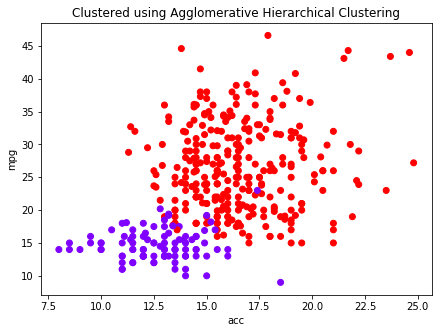

In [80]:
plt.figure(figsize=(7, 5))
plt.title("Clustered using Agglomerative Hierarchical Clustering")
plt.xlabel("acc")
plt.ylabel("mpg")
plt.scatter(df['acc'], df['mpg'], c=clusters, cmap='rainbow')  # plot points with cluster dependent colors
plt.show()

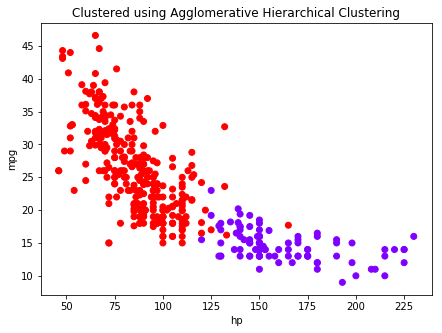

In [81]:
plt.figure(figsize=(7, 5))
plt.title("Clustered using Agglomerative Hierarchical Clustering")
plt.xlabel("hp")
plt.ylabel("mpg")
plt.scatter(df['hp'], df['mpg'], c=clusters, cmap='rainbow')  # plot points with cluster dependent colors
plt.show()

In [82]:
df.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg', 'company'], dtype='object')

In [83]:
def run_linear_regression(df_all):
    res = pd.DataFrame(index=['Train', 'Test'])
    coeff = pd.DataFrame()
    for key, df_cluster in df_all.items():
        if (df_cluster.shape[0] > 0):
            # k is combination of key (key is just an identifier for provided dataframe) 
            # & the no of rows in the the given dataframe.
            k = "{}_{}".format(key, df_cluster.shape[0])
            X = df_cluster.drop('mpg', axis=1)
            #print(X.head(1))
            y = df_cluster['mpg']
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
            #print(X_train.shape)
            #print(X_test.shape)
            lm = LinearRegression()
            lm.fit(X_train, y_train)
            y_pred = lm.predict(X_test)
            #print(lm.coef_)
            train_score = lm.score(X_train, y_train)
            test_score = lm.score(X_test, y_test)
            res[k] = [train_score, test_score]
            coeff[key] = lm.coef_
            asterisks = '*'*50
            #print(asterisks)            
            #print("Train Score (R2) = ", train_score)
            #print("Test  Score (R2) = ", test_score)
            #print(asterisks)
    return res, coeff

## 4. Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)

### Test#1 : Build Linear Regression model with all the variables except 'car name', dummies created for 'yr' & 'company'. Data is clustered according to Agglomerative Clustering (But can be easily replaced with KMeans Clustering too)

In [84]:
df_main = df.copy()
df_main = df_main.drop(['car name'], axis=1)
df_main['cluster'] = clusters
df_main = pd.get_dummies(df_main, columns=['yr', 'company'], drop_first=True)

df0 = df_main[df_main['cluster'] == 0]
df1 = df_main[df_main['cluster'] == 1]
df2 = df_main[df_main['cluster'] == 2]

df_main = df_main.drop(['cluster'], axis=1)
df0 = df0.drop(['cluster'], axis=1)
df1 = df1.drop(['cluster'], axis=1)
df2 = df2.drop(['cluster'], axis=1)


df_all = {"All": df_main, "C1": df0, "C2" : df1, "C3" : df2}
res, coeff = run_linear_regression(df_all)
res

,All_397,C1_98,C2_299
Train,0.905108,0.733087,0.879776
Test,0.799250,0.579336,0.800431


### Test#1 Print the coefficients

In [85]:
indices = df0.columns.drop('mpg')
coeff.set_index(indices, inplace=False)

,All,C1,C2
cyl,-4.178241e-01,1.115194e+11,3.699541e-01
disp,1.960388e-02,-1.757444e-02,8.116673e-03
hp,-4.231496e-02,-3.694152e-02,-1.058839e-01
wt,-5.366895e-03,9.038196e-04,-7.581991e-03
acc,-9.159044e-02,-7.002300e-01,-7.755868e-02
yr_71,1.229016e-01,-6.260361e-01,1.846958e-01
yr_72,-3.536663e-01,-8.274557e-01,-5.714951e-01
yr_73,-7.081015e-01,-7.211670e-01,-1.548497e+00
yr_74,1.256667e+00,-4.857279e-01,1.157478e+00
yr_75,7.180404e-01,-6.534227e-01,1.657370e+00


### Test#2 : Build Linear Regression model with only limited variables 'disp', 'acc' & dummies of 'yr' & 'company'. Data is clustered according to Agglomerative Clustering (But can be easily replaced with KMeans Clustering too)

In [86]:
df.corr()
# disp has the maximum (-ve) correlation coefficient value with mpg. So disp will go in model building. Also since disp has high
# correlation with cyl, hp & wt, disp would represent all these indenpendent variables.
# Additionally, acc, yr and company will also go in model building.

,cyl,disp,hp,wt,acc,yr,mpg
cyl,1.000000,0.950798,0.840902,0.896239,-0.506078,-0.348481,-0.775338
disp,0.950798,1.000000,0.896036,0.932862,-0.543955,-0.370218,-0.804261
hp,0.840902,0.896036,1.000000,0.864352,-0.689265,-0.414088,-0.778556
wt,0.896239,0.932862,0.864352,1.000000,-0.417458,-0.306838,-0.831955
acc,-0.506078,-0.543955,-0.689265,-0.417458,1.000000,0.289056,0.420909
yr,-0.348481,-0.370218,-0.414088,-0.306838,0.289056,1.000000,0.579117
mpg,-0.775338,-0.804261,-0.778556,-0.831955,0.420909,0.579117,1.000000


In [87]:
df_main = df.copy()
df_main = df_main.drop(['car name', 'cyl', 'hp', 'wt'], axis=1)
df_main['cluster'] = clusters
df_main = pd.get_dummies(df_main, columns=['yr', 'company'], drop_first=True)

df0 = df_main[df_main['cluster'] == 0]
df1 = df_main[df_main['cluster'] == 1]
df2 = df_main[df_main['cluster'] == 2]

df_main = df_main.drop(['cluster'], axis=1)
df0 = df0.drop(['cluster'], axis=1)
df1 = df1.drop(['cluster'], axis=1)
df2 = df2.drop(['cluster'], axis=1)

df_all = {"All": df_main, "C1": df0, "C2" : df1, "C3" : df2}
res, coeff = run_linear_regression(df_all)
res

,All_397,C1_98,C2_299
Train,0.869581,0.737864,0.795035
Test,0.736057,0.662791,0.660338


### Test#2 Print the coefficients

In [88]:
indices = df0.columns.drop('mpg')
coeff.set_index(indices, inplace=False)

,All,C1,C2
disp,-4.280613e-02,-2.418532e-02,-7.166298e-02
acc,-2.296474e-02,-6.215546e-01,1.236600e-01
yr_71,-1.286952e+00,-3.048378e-01,7.412745e-01
yr_72,-3.197599e+00,-6.235101e-02,-3.098868e+00
yr_73,-2.884906e+00,-2.275641e-01,-2.449493e+00
yr_74,-1.284847e+00,7.122999e-01,6.200596e-02
yr_75,-1.791955e+00,5.882302e-01,6.399571e-01
yr_76,-7.426410e-01,7.021831e-01,3.698393e-01
yr_77,-5.724021e-01,1.910237e+00,4.775256e-01
yr_78,-1.144234e-01,4.352427e+00,1.610293e+00


### Test#3 : Build Linear Regression model with only limited variables 'hp', 'acc' & dummies of 'yr' & 'company'. Additionally I am putting in squared value of hp. Data is clustered according to Agglomerative Clustering (But can be easily replaced with KMeans Clustering too)

In [89]:
df_main = df.copy()
df_main = df_main.drop(['car name', 'cyl', 'disp', 'wt'], axis=1)
df_main['hp_2'] = np.power(df_main['hp'], 2)
df_main['cluster'] = clusters
df_main = pd.get_dummies(df_main, columns=['yr', 'company'], drop_first=True)

df0 = df_main[df_main['cluster'] == 0]
df1 = df_main[df_main['cluster'] == 1]
df2 = df_main[df_main['cluster'] == 2]

df_main = df_main.drop(['cluster'], axis=1)
df0 = df0.drop(['cluster'], axis=1)
df1 = df1.drop(['cluster'], axis=1)
df2 = df2.drop(['cluster'], axis=1)

df_all = {"All": df_main, "C1": df0, "C2" : df1, "C3" : df2}
res, coeff = run_linear_regression(df_all)
res

,All_397,C1_98,C2_299
Train,0.922996,0.771224,0.848025
Test,0.813329,0.742710,0.783049


### Test#3 Print the coefficients

In [90]:
indices = df0.columns.drop('mpg')
coeff.set_index(indices, inplace=False)

,All,C1,C2
hp,-4.357268e-01,-1.282802e-01,-5.890072e-01
acc,-7.048862e-01,-5.461342e-01,-7.334638e-01
hp_2,1.133867e-03,2.350495e-04,1.838056e-03
yr_71,6.240987e-02,-1.234868e+00,6.596287e-01
yr_72,2.396058e-02,-6.368787e-01,-1.415225e-01
yr_73,-5.464350e-01,-7.159276e-01,-1.012691e+00
yr_74,7.193868e-01,-1.371103e-01,4.663717e-01
yr_75,3.891857e-01,-5.000072e-01,1.583680e-01
yr_76,9.075967e-01,3.575926e-02,3.548594e-01
yr_77,2.081054e+00,1.356763e+00,1.589916e+00


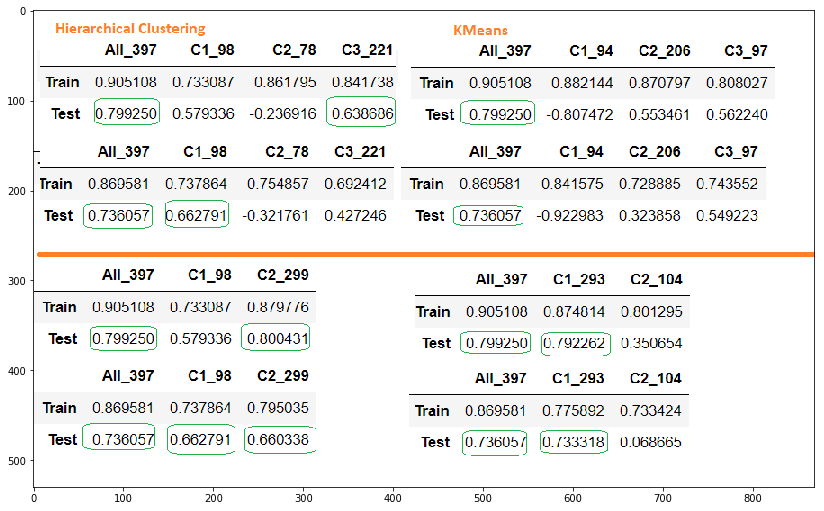

In [91]:
plt.figure(figsize = (14, 10))
plt.imshow(plt.imread("Linear_Regression_Readings_Edited.png"))